# KnowMore Notebook Edition

## 1. Enter Ids of datasets of interest

In [18]:
list_datasetids = ['60', '64', '65']
#list_datasetids = ['60', '64', '65', '16', '61', '82', '89']

# 2. Run data processing jobs on osparc

In [2]:
import matplotlib
%matplotlib inline
from pylab import *
import osparc
import time
from pathlib import Path
from osparc.api import FilesApi, SolversApi
from osparc.models import File, Job, JobInputs, JobOutputs, JobStatus, Solver
import os
import json
from zipfile import ZipFile
import shutil
import seaborn as sns

rcParams["figure.figsize"] = 20,10


import pandas as pd
print(osparc.__version__)

OSPARC_API_KEY = os.environ['OSPARC_API_KEY']
OSPARC_API_SECRET = os.environ['OSPARC_API_SECRET']

cfg = osparc.Configuration(
    username=OSPARC_API_KEY,
    password=OSPARC_API_SECRET,
)
print(cfg.host)

#Save user selected datasetid in json
current_folder = os.getcwd()
main_folder = os.path.dirname(current_folder)
asset_input_folder = os.path.join(main_folder, 'assets', 'INPUT_FOLDER')
local_input_folder = os.path.join(asset_input_folder, 'tmp', 'fake-uuid-for-sample-data', 'INPUT_FOLDER')
local_output_folder = os.path.join(main_folder, 'static', 'notebook-output')
input_file = {}
input_file["datasetIds"] = list_datasetids
input_json_save_file = os.path.join(local_input_folder, 'input.json')
with open(input_json_save_file, 'w+') as f:
    # this would place the entire output on one line
    # use json.dump(lista_items, f, indent=4) to "pretty-print" with four spaces per indent
    json.dump(input_file, f)

with osparc.ApiClient(cfg) as api_client:

    files_api = FilesApi(api_client)
    
    print("-------------------------------")
    print("Running Python Runner on osparc")
    
    input_file_path = os.path.join(local_input_folder, 'input.json')
    input_file1: File = files_api.upload_file(file=os.path.join(asset_input_folder, "main.zip"))
    input_file2: File = files_api.upload_file(file=input_file_path)

    solvers_api = SolversApi(api_client)
    solver: Solver = solvers_api.get_solver_release(
        "simcore/services/comp/osparc-python-runner", "1.2.0"
    )

    job: Job = solvers_api.create_job(
        solver.id,
        solver.version,
        JobInputs(
            {
                "input_2": input_file2,
                "input_1": input_file1,
            }
        ),
    )

    status: JobStatus = solvers_api.start_job(solver.id, solver.version, job.id)
    
    while not status.stopped_at:
        time.sleep(5)
        status = solvers_api.inspect_job(solver.id, solver.version, job.id)
        print("Solver progress", f"{status.progress}/100", flush=True)

    outputs: JobOutputs = solvers_api.get_job_outputs(solver.id, solver.version, job.id)

    print(f"Job {outputs.job_id} got these results:")
    for output_name, result in outputs.results.items():
        print(output_name, "=", result)

    results_file: File = outputs.results["output_1"]
    download_path: str = files_api.download_file(file_id=results_file.id)
    if os.path.isfile(download_path) or os.path.isdir(download_path):
        print("Unzipping outputs")
        if os.path.isdir(local_output_folder):
            shutil.rmtree(local_output_folder)
        os.makedirs(local_output_folder)
        with ZipFile(download_path, 'r') as zipObj:
            zipObj.extractall(local_output_folder)
        print("Unzipped at ", local_output_folder)

    print("-------------------------------")
    print("Running custome Matlab script on osparc")  
    if os.path.isdir(os.path.join(local_output_folder, 'matlab-input-folder')):
        matlab_plots = 1
        input_file_path = os.path.join(local_output_folder, 'matlab-input-folder.zip')
        input_file1: File = files_api.upload_file(file=input_file_path)

        solvers_api = SolversApi(api_client)
        solver: Solver = solvers_api.get_solver_release(
            "simcore/services/comp/mat-parser", "1.1.0"
        )

        job: Job = solvers_api.create_job(
            solver.id,
            solver.version,
            JobInputs(
                {
                    "input_1": input_file1,
                }
            ),
        )

        status: JobStatus = solvers_api.start_job(solver.id, solver.version, job.id)
        while not status.stopped_at:
            time.sleep(5)
            status = solvers_api.inspect_job(solver.id, solver.version, job.id)
            print("Solver progress", f"{status.progress}/100", flush=True)

        outputs: JobOutputs = solvers_api.get_job_outputs(solver.id, solver.version, job.id)

        print(f"Job {outputs.job_id} got these results:")
        for output_name, result in outputs.results.items():
            print(output_name, "=", result)

        results_file: File = outputs.results["output_1"]
        download_path: str = files_api.download_file(file_id=results_file.id)
        print(download_path)
        if os.path.isfile(download_path) or os.path.isdir(download_path):
            print("Unzipping outputs")
            with ZipFile(download_path, 'r') as zipObj:
                zipObj.extractall(local_output_folder) 
    else:
        matlab_plots = 0
        print('No tabular data applicable for these datasets')

0.4.3
https://api.osparc.io
-------------------------------
Running Python Runner on osparc
Solver progress 0/100
Solver progress 0/100
Solver progress 0/100
Solver progress 0/100
Solver progress 0/100
Solver progress 0/100
Solver progress 0/100
Solver progress 0/100
Solver progress 0/100
Solver progress 0/100
Solver progress 0/100
Solver progress 0/100
Solver progress 0/100
Solver progress 0/100
Solver progress 0/100
Solver progress 0/100
Solver progress 0/100
Solver progress 0/100
Solver progress 0/100
Solver progress 0/100
Solver progress 0/100
Solver progress 0/100
Solver progress 0/100
Solver progress 0/100
Solver progress 0/100
Solver progress 100/100
Job 58d279e8-2729-4f52-8195-69edc41a082b got these results:
output_1 = {'checksum': '9dcb2fc3df28e1c8a62092d62cc79ec6',
 'content_type': 'application/zip',
 'filename': 'output_data.zip',
 'id': 'a4ec70f3-2d52-341b-9c77-3744ab6ff4b0'}
Unzipping outputs
Unzipped at  C:\Users\Calmi2\Documents\GitHub\KnowMore-py\static\notebook-output


# 3. Visualize results

## Summary Table

In [3]:
## Show summary table from output.json data

In [5]:
current_folder = os.getcwd()
main_folder = os.path.dirname(current_folder)
notebook_output_folder = os.path.join(main_folder, 'static', "notebook-output")
output_json_file = os.path.join(notebook_output_folder, "output.json")
data = json.load(open(output_json_file))

In [6]:
summary_table = pd.DataFrame(data["summary table"])
summary_table

,60,64,65
Age,75 days - 268 days,10.5 weeks - 15 weeks,54 years - 90+ years
Anatomical location(s),[left cervical vagus nerve; 13.5 mm from carot...,[left cervical vagus nerve; 13 cm from bottom ...,[left cervical vagus nerve; 30 mm from carotid...
Dataset id,60,64,65
Number of samples,18,18,20
Number of subjects,10,11,15
Publication_date,2020-09-30,2020-10-01,2020-10-01
Sex,"[Female, Male]","[Female, Male]","[Female, Male]"
Species,Rattus norvegicus,Sus scrofa domesticus,Homo sapiens
Specimen type,vagus nerve,vagus nerve,vagus nerve
Subtitle,Binary traces from segmentation of cross secti...,Binary traces from segmentation of cross secti...,Immunohistochemistry micrographs of human vagu...


## Keywords

Text(0.5, 1.0, '20 Most occuring keywords')

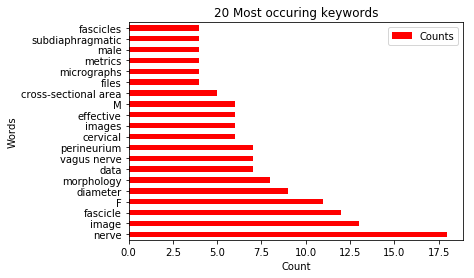

In [7]:
# Show plot of the keywords from output.json data  using horizontal bars like this: https://cdn.fightforsmall.com/depictdatastudio.com/2017/01/Depict-Data-Studio_Bar-Charts_Vertical-or-Horizontal_Horizontal-1.jpg 


key_words= {'Words':list(data["keywords"].keys()), 'Counts':list(data["keywords"].values())}
key_words = pd.DataFrame(key_words).set_index("Words")
plot = key_words.plot.barh(color="red")
plot.set_xlabel("Count")
plot.set_title("20 Most occuring keywords")


## Abstract

In [8]:
# Show the correlation matrix from output.json data

Text(0.5, 1.0, 'Correlation Matrix')

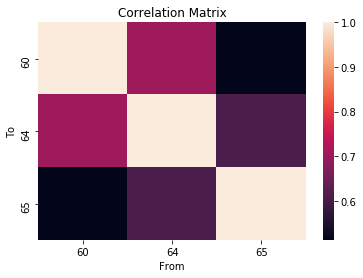

In [9]:
plot = sns.heatmap(pd.read_json(data["correlation_matrix"]))
plot.set_xlabel("From")
plot.set_ylabel("To")
plot.set_title("Correlation Matrix")

In [10]:
# Show seaborntract text from output.json data
data["abstract"]

'Neurolucida 360 from MBF Bioscience was used to convert the binary traces into xml file format to overlay with the original Masson’s trichrome nd2 micrographs (in prior dataset) and then to convert the images to jp2 extension (in derived folder). The dataset contains TIFF files for 9 left cervical and 9 anterior subdiaphragmatic human vagus nerve samples, providing segmented traces of inner and outer perineurial boundaries, as well as outer nerve boundaries. The __derivative folder__ contains a .mat file with the morphology metrics output by the code, as well as xml and jp2 versions of the image files; Neurolucida 360 from MBF Bioscience was used to convert the binary traces into xml file format to overlay with the original Masson’s trichrome nd2 micrographs (in prior dataset) and then to convert the images to jp2 extension.  To quantify rat vagus nerve morphology Using micrographs of rat vagus nerve cross sections that were stained with Masson’s trichrome, we quantified effective ner

## Data Plots

In [9]:
# Plot using matlab_output.xlsx , plot all the sheets that include the word "Plot" in their name

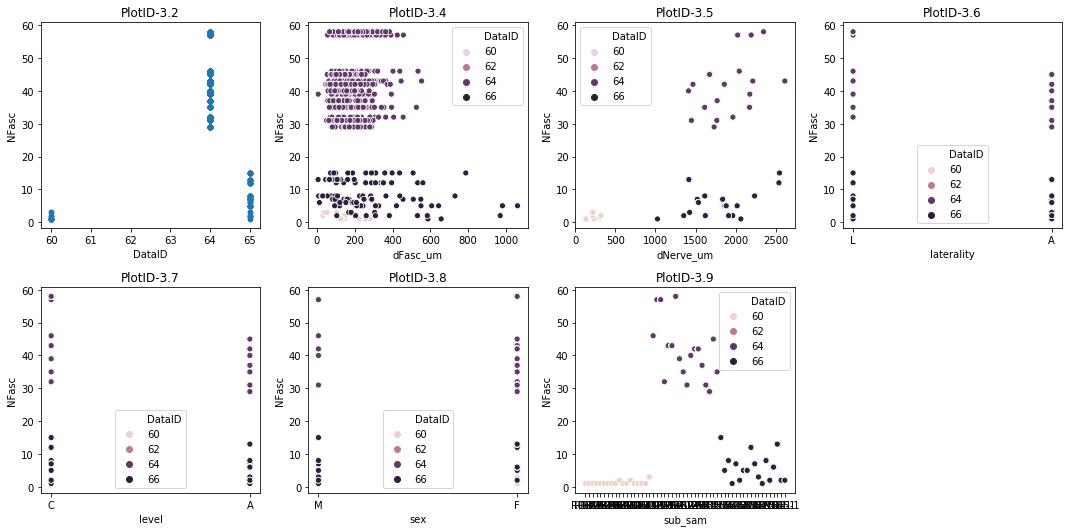

In [17]:
matlab_output_file = os.path.join(notebook_output_folder, "matlab_output.xlsx")
plt3_2 = pd.read_excel(matlab_output_file,sheet_name="PlotID-3.2")
plt3_4 = pd.read_excel(matlab_output_file,sheet_name="PlotID-3.4")
plt3_4["DataID"] = plt3_4["DataID"].apply(str)
plt3_5 = pd.read_excel(matlab_output_file,sheet_name="PlotID-3.5")
plt3_5["DataID"] = plt3_5["DataID"].apply(str)
plt3_6 = pd.read_excel(matlab_output_file,sheet_name="PlotID-3.6")
plt3_7 = pd.read_excel(matlab_output_file,sheet_name="PlotID-3.7")
plt3_8 = pd.read_excel(matlab_output_file,sheet_name="PlotID-3.8")
plt3_9 = pd.read_excel(matlab_output_file,sheet_name="PlotID-3.9")
fig, axs = plt.subplots(2, 4)
fig.set_figheight(7.5)
fig.set_figwidth(15)
plt3_2.plot.scatter(x="DataID", y="NFasc", ax= axs[0,0])
axs[0,0].set_title("PlotID-3.2")
sns.scatterplot(data=plt3_4,x="dFasc_um", y="NFasc", hue="DataID", ax=axs[0,1])
axs[0,1].set_title("PlotID-3.4")
sns.scatterplot(data=plt3_5,x="dNerve_um", y="NFasc", hue="DataID", ax=axs[0,2])
axs[0,2].set_title("PlotID-3.5")
sns.scatterplot(data=plt3_6,x="laterality", y="NFasc", hue="DataID", ax=axs[0,3])
axs[0,3].set_title("PlotID-3.6")
sns.scatterplot(data=plt3_7,x="level", y="NFasc", hue="DataID", ax=axs[1,0])
axs[1,0].set_title("PlotID-3.7")
sns.scatterplot(data=plt3_8,x="sex", y="NFasc", hue="DataID", ax=axs[1,1])
axs[1,1].set_title("PlotID-3.8")
sns.scatterplot(data=plt3_9,x="sub_sam", y="NFasc", hue="DataID", ax=axs[1,2])
axs[1,2].set_title("PlotID-3.9")
fig.delaxes(axs[1,3])
fig.tight_layout()

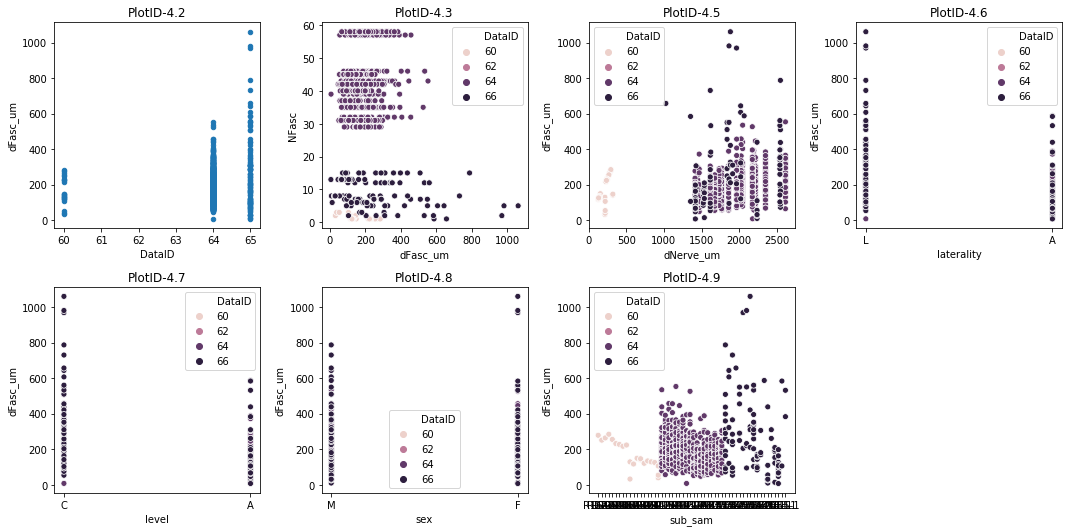

In [15]:
plt4_2 = pd.read_excel(matlab_output_file,sheet_name="PlotID-4.2")
plt4_3 = pd.read_excel(matlab_output_file,sheet_name="PlotID-4.3")
plt4_3["DataID"] = plt4_3["DataID"].apply(str)
plt4_5 = pd.read_excel(matlab_output_file,sheet_name="PlotID-4.5")
plt4_5["DataID"] = plt4_5["DataID"].apply(str)
plt4_6 = pd.read_excel(matlab_output_file,sheet_name="PlotID-4.6")
plt4_7 = pd.read_excel(matlab_output_file,sheet_name="PlotID-4.7")
plt4_8 = pd.read_excel(matlab_output_file,sheet_name="PlotID-4.8")
plt4_9 = pd.read_excel(matlab_output_file,sheet_name="PlotID-4.9")
fig, axs = plt.subplots(2, 4)
fig.set_figheight(7.5)
fig.set_figwidth(15)
plt4_2.plot.scatter(x="DataID", y="dFasc_um", ax= axs[0,0])
axs[0,0].set_title("PlotID-4.2")
sns.scatterplot(data=plt4_3,x="dFasc_um", y="NFasc", hue="DataID", ax=axs[0,1])
axs[0,1].set_title("PlotID-4.3")
sns.scatterplot(data=plt4_5,x="dNerve_um", y="dFasc_um", hue="DataID", ax=axs[0,2])
axs[0,2].set_title("PlotID-4.5")
sns.scatterplot(data=plt4_6,x="laterality", y="dFasc_um", hue="DataID", ax=axs[0,3])
axs[0,3].set_title("PlotID-4.6")
sns.scatterplot(data=plt4_7,x="level", y="dFasc_um", hue="DataID", ax=axs[1,0])
axs[1,0].set_title("PlotID-4.7")
sns.scatterplot(data=plt4_8,x="sex", y="dFasc_um", hue="DataID", ax=axs[1,1])
axs[1,1].set_title("PlotID-4.8")
sns.scatterplot(data=plt4_9,x="sub_sam", y="dFasc_um", hue="DataID", ax=axs[1,2])
axs[1,2].set_title("PlotID-4.9")
fig.delaxes(axs[1,3])
fig.tight_layout()

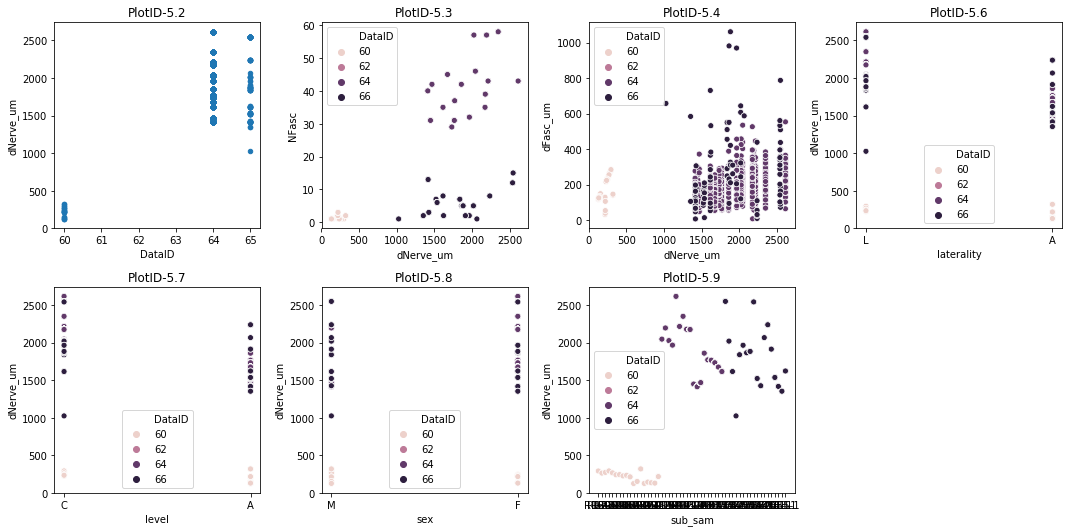

In [16]:
plt5_2 = pd.read_excel(matlab_output_file,sheet_name="PlotID-5.2")
plt5_3 = pd.read_excel(matlab_output_file,sheet_name="PlotID-5.3")
plt5_3["DataID"] = plt5_3["DataID"].apply(str)
plt5_4 = pd.read_excel(matlab_output_file,sheet_name="PlotID-5.4")
plt5_4["DataID"] = plt5_4["DataID"].apply(str)
plt5_6 = pd.read_excel(matlab_output_file,sheet_name="PlotID-5.6")
plt5_7 = pd.read_excel(matlab_output_file,sheet_name="PlotID-5.7")
plt5_8 = pd.read_excel(matlab_output_file,sheet_name="PlotID-5.8")
plt5_9 = pd.read_excel(matlab_output_file,sheet_name="PlotID-5.9")
fig, axs = plt.subplots(2, 4)
fig.set_figheight(7.5)
fig.set_figwidth(15)
plt5_2.plot.scatter(x="DataID", y="dNerve_um", ax= axs[0,0])
axs[0,0].set_title("PlotID-5.2")
sns.scatterplot(data=plt5_3,x="dNerve_um", y="NFasc", hue="DataID", ax=axs[0,1])
axs[0,1].set_title("PlotID-5.3")
sns.scatterplot(data=plt5_4,x="dNerve_um", y="dFasc_um", hue="DataID", ax=axs[0,2])
axs[0,2].set_title("PlotID-5.4")
sns.scatterplot(data=plt5_6,x="laterality", y="dNerve_um", hue="DataID", ax=axs[0,3])
axs[0,3].set_title("PlotID-5.6")
sns.scatterplot(data=plt5_7,x="level", y="dNerve_um", hue="DataID", ax=axs[1,0])
axs[1,0].set_title("PlotID-5.7")
sns.scatterplot(data=plt5_8,x="sex", y="dNerve_um", hue="DataID", ax=axs[1,1])
axs[1,1].set_title("PlotID-5.8")
sns.scatterplot(data=plt5_9,x="sub_sam", y="dNerve_um", hue="DataID", ax=axs[1,2])
axs[1,2].set_title("PlotID-5.9")
fig.delaxes(axs[1,3])
fig.tight_layout()